In [391]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
from matplotlib import rc,rcParams
from aacgmv2 import convert
rc('text', usetex=True)
rcParams['figure.figsize'] = (11., 6)

In [138]:
!wget 'http://legacy-www.swpc.noaa.gov/wingkp/wingkp_list.txt'
!wget 'http://services.swpc.noaa.gov/text/aurora-nowcast-map.txt'
!wget 'http://services.swpc.noaa.gov/text/goes-particle-flux-primary.txt'

--2017-04-29 20:51:02--  http://legacy-www.swpc.noaa.gov/wingkp/wingkp_list.txt
Resolving legacy-www.swpc.noaa.gov (legacy-www.swpc.noaa.gov)... 140.172.17.11, 140.172.17.21, 216.38.80.71, ...
Connecting to legacy-www.swpc.noaa.gov (legacy-www.swpc.noaa.gov)|140.172.17.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77628 (76K) [text/plain]
Saving to: ‘wingkp_list.txt.2’

wingkp_list.txt.2   100%[===================>]  75,81K  18,9KB/s    in 4,0s    

2017-04-29 20:51:18 (18,9 KB/s) - ‘wingkp_list.txt.2’ saved [77628/77628]

--2017-04-29 20:51:18--  http://services.swpc.noaa.gov/text/aurora-nowcast-map.txt
Resolving services.swpc.noaa.gov (services.swpc.noaa.gov)... 216.38.80.81, 129.15.96.11, 129.15.96.21, ...
Connecting to services.swpc.noaa.gov (services.swpc.noaa.gov)|216.38.80.81|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2098423 (2,0M) [text/plain]
Saving to: ‘aurora-nowcast-map.txt.3’

aurora-nowcast-map. 100%[===========

In [664]:
kpl=np.loadtxt('wingkp_list.txt',comments=[':','#'])
aurora=np.loadtxt('aurora-nowcast-map.txt')
flight=np.loadtxt('Data/BIKF-NZAA.csv',delimiter=',',dtype=str)
fluxdata=np.loadtxt('goes-particle-flux-primary.txt',comments=[':','#'])
flat=flight[:,3].astype(float)
flon=flight[:,4].astype(float)
Kphi=[66.5,64.5,62.4,60.4,58.3,56.3,54.2,52.2,50.1,48.1]
kp=kpl[:,17][0]
kp=9
maxphi=Kphi[int(kp)]
alt=13.

## Συνάρτηση ύψους (ελλειψοειδες)
$$
H(\lambda,\phi)=\frac{ab}{(a\cos \lambda)^2+(b\sin \lambda)^2}
$$

In [665]:
def H(lon,lat,zone='ion'):
    D={'tropo':[20.,7.],'strato':[50.,17.5],'meso':[85.,29.7],'ion':[120.,42.]}
    a=D[zone]
    return a[0]*a[1]/np.sqrt((a[1]*np.cos(lat*np.pi/180.))**2+(a[0]*np.sin(lat*np.pi/180.))**2)

In [666]:
nlats = 256
nlons = 256
lats=np.linspace(-90,90,nlats)
lons=np.linspace(-180,180,nlons)
glatN=maxphi*np.ones(nlats)
glonN=np.linspace(-180,180,nlons)
mlatN,mlonN=convert(glatN,glonN,alt)
glatS=-maxphi*np.ones(nlats)
glonS=np.linspace(-180,180,nlons)
mlatS,mlonS=convert(glatS,glonS,alt)

In [667]:
mS=interp1d(np.roll(mlonS,-mlonS.argmin()),np.roll(mlatS,-mlonS.argmin()),fill_value='extrapolate')
mN=interp1d(np.roll(mlonN,-mlonN.argmin()),np.roll(mlatN,-mlonN.argmin()),fill_value='extrapolate')

In [668]:
f1=fluxdata[:,12][0]*p#Electron Flux >0.8 Mev
f2=fluxdata[:,13][0]*p#Electron Flux >2 Mev
f3=fluxdata[:,14][0]*p if data[:,14][0]>0. else 0. #Electron Flux >4 Mev

In [669]:
def F1(lon,lat,F10,alt=13.,S1=1.680):
    return (F10-S1*(H(lon,lat)-alt))
def F2(lon,lat,F20,alt=13.,S2=1.783):
    return F20-S2*(H(lon,lat)-alt)
def F3(lon,lat,F30,alt=13.,S3=1.85):
    return F30-S3*(H(lon,lat)-alt)
def Fcr(lon,lat,alt=13.):
    return 10**((10./3) *np.log10(alt)-1./3)

In [636]:
p=0.0934
F1=fluxdata[:,12][0]*p*np.ones((nlons,nlats)) #Electron Flux >0.8 Mev
F2=fluxdata[:,13][0]*p*np.ones((nlons,nlats)) #Electron Flux >2 Mev
F3=fluxdata[:,14][0]*p*np.ones((nlons,nlats)) if data[:,14][0]>0. else np.zeros((nlons,nlats)) #Electron Flux >4 Mev
Fcr=np.zeros((nlons,nlats))
layers=['tropo','strato','meso','ion']
S1={'tropo': 1.680,'strato':1.680,'meso':1.68,'ion':1.68}
S2={'tropo': 1.783,'strato': 1.783,'meso': 1.783,'ion':1.783}
S3={'tropo':  1.85,'strato':  1.85,'meso': 1.85,'ion':1.85}
for j,lon in enumerate(lons):
    for i,lat in enumerate(lats):
#             clat=convert(lat,lon,alt)[0]
#             latN=convert(maxphi,lon,alt)[0]
#             latS=convert(-maxphi,lon,alt)[0]
            layer='ion'
            if lat>mN(lon):
                F1[i,j]=F1[i,j]-S1[layer]*(H(lon,lat,layer)-alt)
                F2[i,j]=F2[i,j]-S2[layer]*(H(lon,lat,layer)-alt)
                F3[i,j]=F3[i,j]-S2[layer]*(H(lon,lat,layer)-alt)
                Fcr[i,j]=10**((10./3) *np.log10(alt)-1./3)
            elif lat<mS(lon):
                F1[i,j]=F1[i,j]-S1[layer]*(H(lon,lat,layer)-alt)
                F2[i,j]=F2[i,j]-S2[layer]*(H(lon,lat,layer)-alt)
                F3[i,j]=F3[i,j]-S2[layer]*(H(lon,lat,layer)-alt)
                Fcr[i,j]=10**((10./3) *np.log10(alt)-1./3)
            else:
                F1[i,j]=0.
                F2[i,j]=0.
                F3[i,j]=0.
                Fcr[i,j]=10**((10./3) *np.log10(alt)-1./3)

In [670]:
prob= [F1(flon[i],flat[i],f1) if convert(flat[i],flon[i],alt)>convert(maxphi,flon[i],alt) else 0. for i in range(flon.shape[0])]

dist=np.array([0.])
for i in range(1,flon.shape[0]):
    df=(flat[i]-flat[i-1])*0.0174533
    phi1=flat[i-1]*0.0174533
    phi2=flat[i]*0.0174533
    dl=(flon[i]-flon[i-1])*0.0174533
    a=np.sin(df/2.)*np.sin(df/2)+np.cos(phi1)*np.cos(phi2)*np.sin(dl/2)*np.sin(dl/2.)
    c=2.*np.arctan2(np.sqrt(a),np.sqrt(1.-a))
    d = 6371. * c
    dist=np.append(dist,dist[-1]+d)

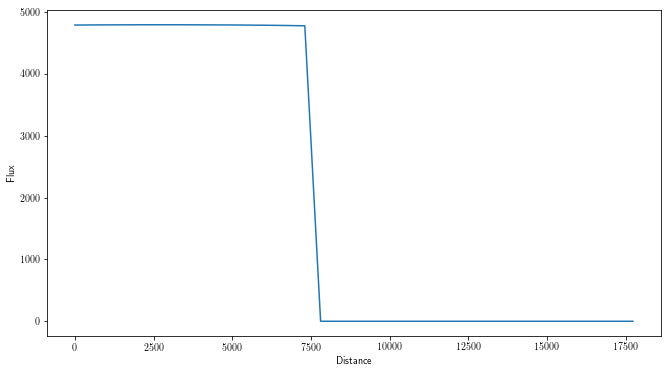

In [678]:
plt.plot(dist,prob)
plt.ylabel('Flux')
plt.xlabel('Distance')

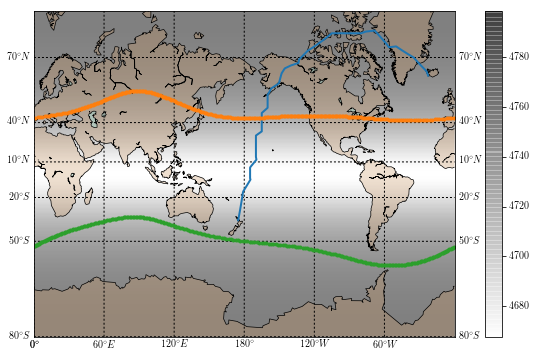

In [677]:
X,Y=np.meshgrid(lons,lats)
#m = Basemap(projection='ortho',lat_0=70,lon_0=-100,resolution='l')
m=Basemap(llcrnrlon=0,llcrnrlat=-80,urcrnrlon=360,urcrnrlat=80,projection='merc')
m.drawcoastlines(linewidth=0.7)
m.fillcontinents(color='#cc9966',lake_color='#99ffff',alpha=0.3)

m.drawparallels(np.arange(-80,81,30),labels=[1,1,0,0])
#m.drawparallels([maxphi,-maxphi],labels=[1,1,0,0])
m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])
#m.contourf(X,Y,aurora,latlon=True,cmap='gist_gray_r')
#cm=m.contourf(X,Y,H(X*np.pi/90./2,Y*np.pi/90./2,'tropo'),latlon=True)
cm=m.imshow(F1(X,Y,f1),cmap='gist_gray_r',alpha=0.5)
plt.colorbar(cm)
m.plot(flon,flat,latlon=True,linewidth=2.)
m.plot(mlonN,mN(mlonN),'.',latlon=True)
m.plot(mlonS,mS(mlonS),'.',latlon=True)